# Horizon Segmentation

Using DeepLabv3 to segment areial images and then extract the horizons.

## Download frozen model

First we download the [trained DeepLabv3 model from GitHub](https://github.com/jahewson/models/blob/1bd2b0cae34c1e986e78d03459209be790199801/research/deeplab/g3doc/iris.md). This was trained on Cloud ML Engine's GPU instances. The dataset used was tiny.

In [ ]:
!wget -q "https://github.com/jahewson/models/releases/download/1.0/frozen_inference_graph_logits.pb"

## DCNN inference with TensorFlow

Semantic segmentation via DeepLabv3 trained with xception65 feature extractor pre-trained on ImageNet.

In [1]:
import time

import tensorflow as tf
import numpy as np
from PIL import Image

In [2]:
def load():
    graph = tf.Graph()
    with tf.gfile.GFile('frozen_inference_graph_logits.pb', 'rb') as file_handle:
        graph_def = tf.GraphDef.FromString(file_handle.read())
    
    if graph_def is None:
        raise RuntimeError('Cannot find inference graph.')
    
    with graph.as_default():
        tf.import_graph_def(graph_def, name='')

    return tf.Session(graph=graph)
    
def run(sess, image):
    input_size = 513
    width, height = image.size
    resize_ratio = 1.0 * input_size / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    
    start_time = time.clock()
    
    batch_seg_map = sess.run('SemanticPredictions:0',
                             feed_dict={'ImageTensor:0': [np.asarray(resized_image)]})
    
    end_time = time.clock()
    print('inference took', end_time - start_time, 'seconds')
    
    seg_map = batch_seg_map[0]
    return resized_image, seg_map
    
sess = load()
img = Image.open('images/image28.png')
img_resized, dcnn_scores = run(sess, img)

inference took 16.734185 seconds


### Visualization

In [3]:
from scipy.special import softmax

# normalize the raw scores to get probabilities
dcnn_probs = softmax(dcnn_scores, axis=2)

# choose labels via maximum likelihood
dcnn_labels = np.argmax(dcnn_probs, axis=2)

In [53]:
from matplotlib import pyplot as plt
from matplotlib import gridspec

def vis_segmentation(image, seg_map, title):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(17, 5))
  plt.suptitle(title, fontsize=16)
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  plt.imshow(seg_map, cmap=plt.cm.get_cmap('rainbow'))
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_map, alpha=0.7, cmap=plt.cm.get_cmap('rainbow'))
  plt.axis('off')
  plt.title('segmentation overlay')

  plt.show()

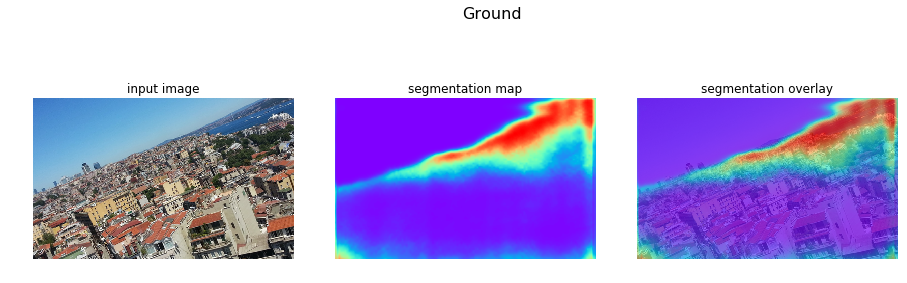

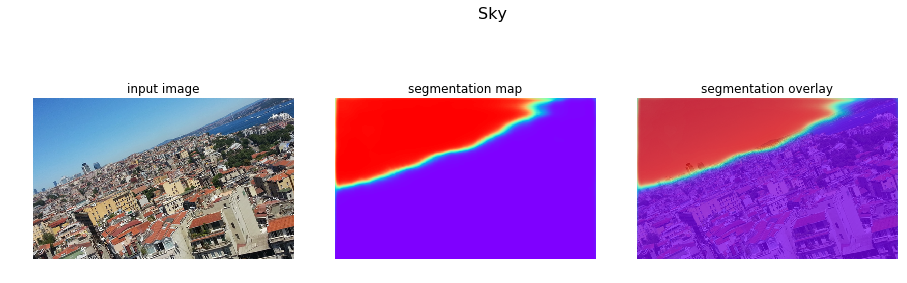

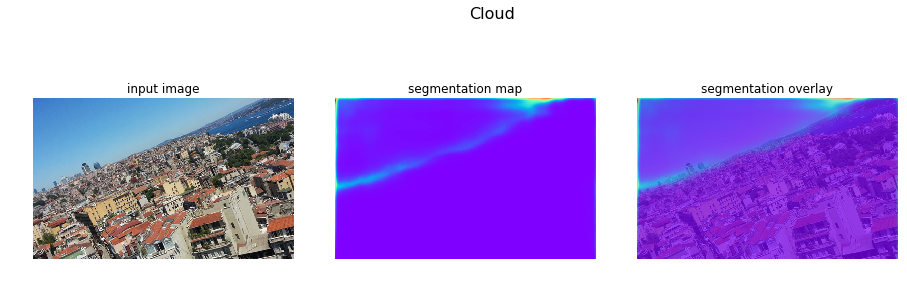

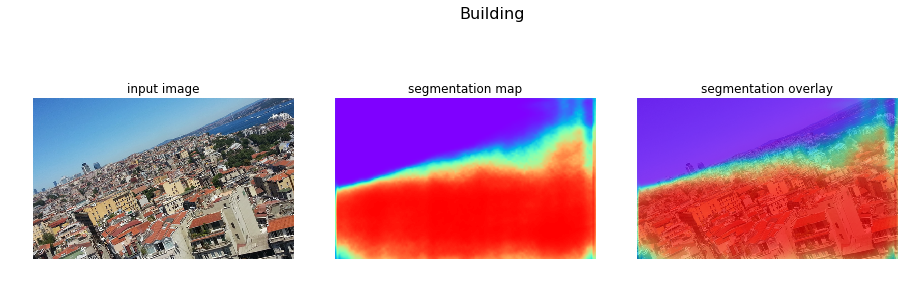

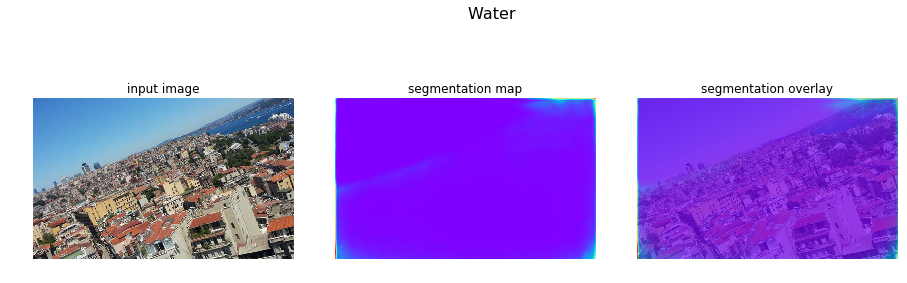

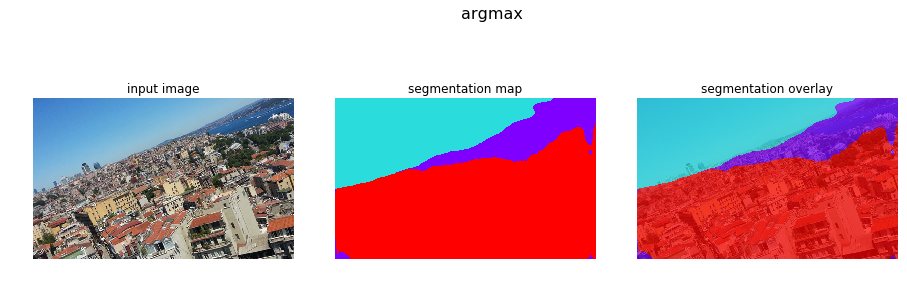

In [54]:
vis_segmentation(img_resized, dcnn_probs[:,:,0], 'Ground')
vis_segmentation(img_resized, dcnn_probs[:,:,1], 'Sky')
vis_segmentation(img_resized, dcnn_probs[:,:,2], 'Cloud')
vis_segmentation(img_resized, dcnn_probs[:,:,3], 'Building')
vis_segmentation(img_resized, dcnn_probs[:,:,4], 'Water')
vis_segmentation(img_resized, dcnn_labels, 'argmax')

## CRF Post-Processing

DeepLabV3 makes use of a CRF for post-processing, which is not part of the TensorFlow model on GitHub. It's neccesary to read the paper to figure out how to do this, here's my take:

In [89]:
import pydensecrf.densecrf as dcrf

In [90]:
from pydensecrf.utils import unary_from_softmax

def crf_postprocess(img, probs):
    width, height, num_labels = probs.shape
    crf = dcrf.DenseCRF2D(width, height, num_labels)
    
    # map probs tensor to a (h*w, ch) matrix
    probs = probs.transpose(2, 0, 1)

    # unary potential: row-major (h*w, ch) matrix
    unary = unary_from_softmax(probs)
    crf.setUnaryEnergy(unary)

    # CRF parameters
    max_iterations = 5

    # pairwise gaussian
    g_potts = 3;
    g_std = 3;

    # pairwise bilateral
    bl_potts = 0
    bl_xy_std = 70
    bl_rgb_std = 5

    # color-independent term (xy)
    crf.addPairwiseGaussian(sxy=(g_std, g_std), compat=g_potts)

    # color-dependent term (xyrgb)
    np_img = np.ascontiguousarray(np.asarray(img).transpose(1, 0, 2))
    crf.addPairwiseBilateral(sxy=(bl_xy_std, bl_xy_std),
                             srgb=(bl_rgb_std, bl_rgb_std, bl_rgb_std),
                             rgbim=np_img, compat=bl_potts)

    # mean field inference
    Q = crf.inference(max_iterations)

    # maximum likelihood
    MAP = np.argmax(Q, axis=0).reshape((img.height, img.width))

    return (Q, MAP)

In [91]:
# perform CRF inference [NOTE that we pass the scores, as DenseCRF does its own normalization]
Q, crf_labels = crf_postprocess(img_resized, dcnn_probs)

# split out the individual channels for visualization
Q_np = np.array(Q)
Q_0 = Q_np[0,:].reshape((img_resized.height, img_resized.width))
Q_1 = Q_np[1,:].reshape((img_resized.height, img_resized.width))
Q_2 = Q_np[2,:].reshape((img_resized.height, img_resized.width))
Q_3 = Q_np[3,:].reshape((img_resized.height, img_resized.width))
Q_4 = Q_np[4,:].reshape((img_resized.height, img_resized.width))

### Visualization

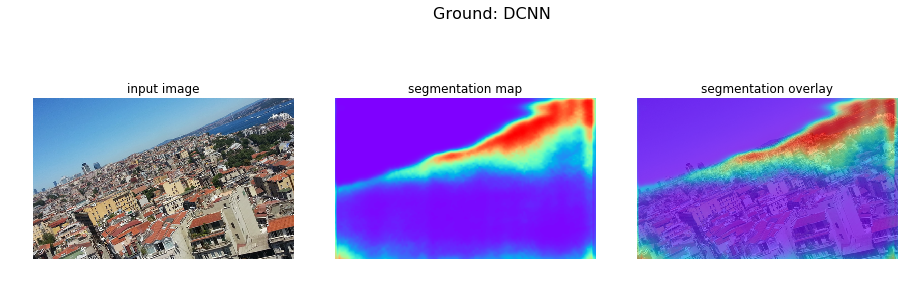

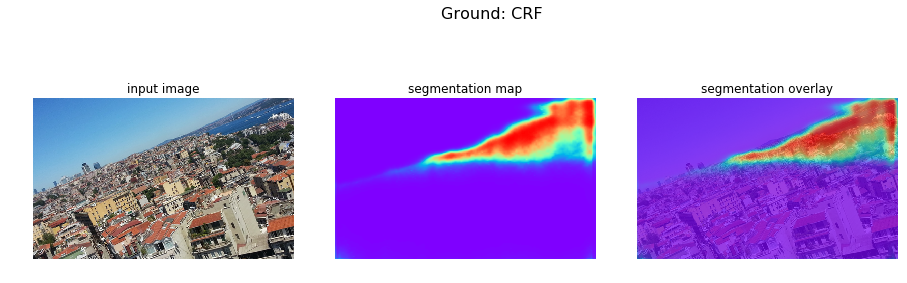

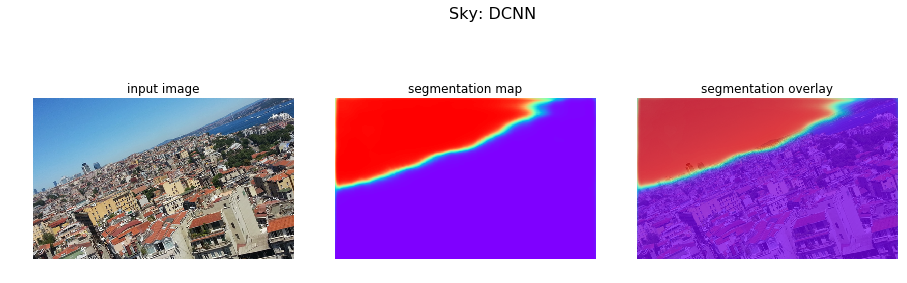

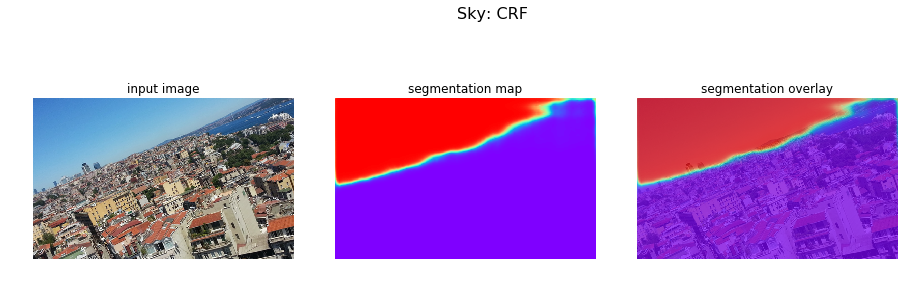

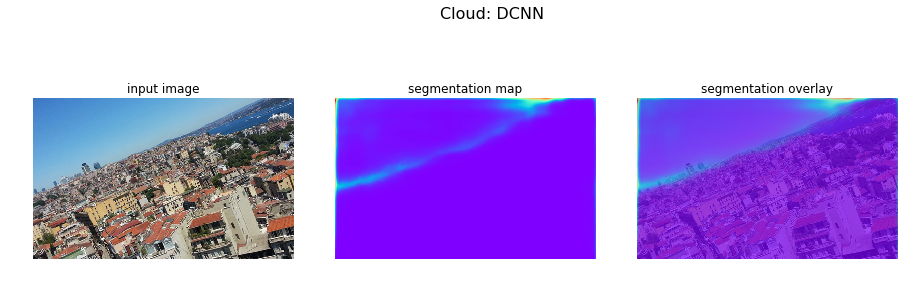

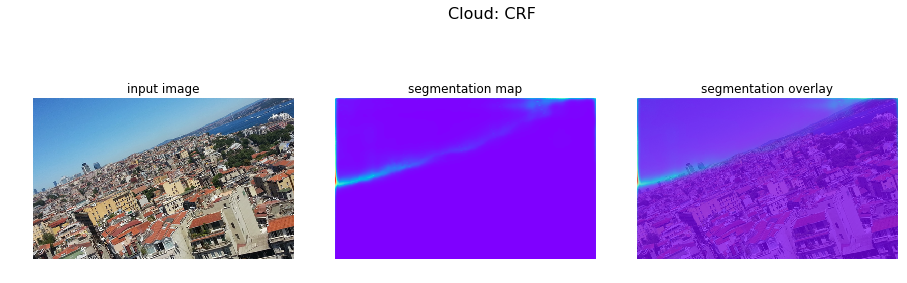

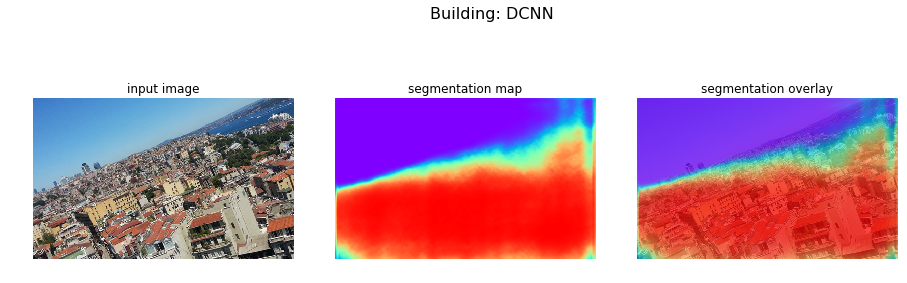

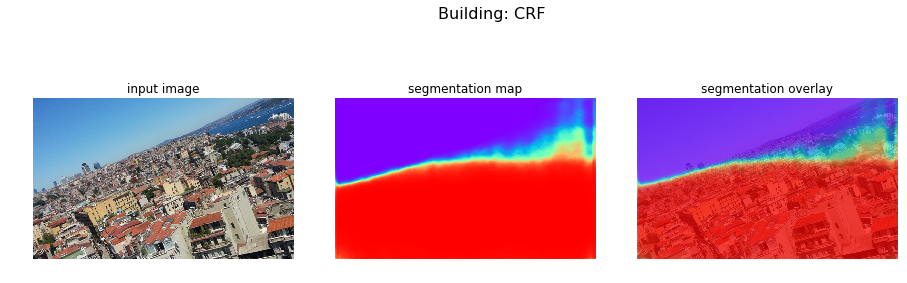

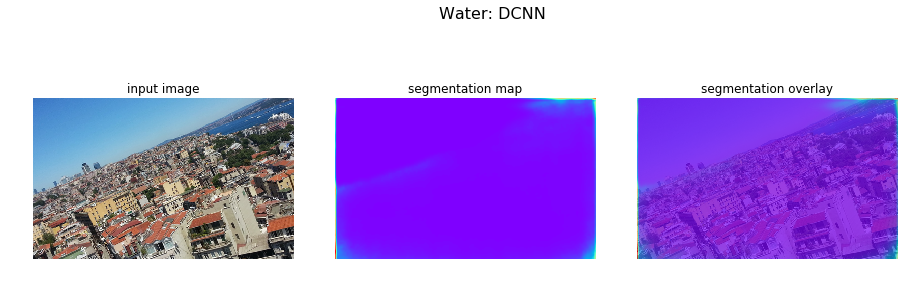

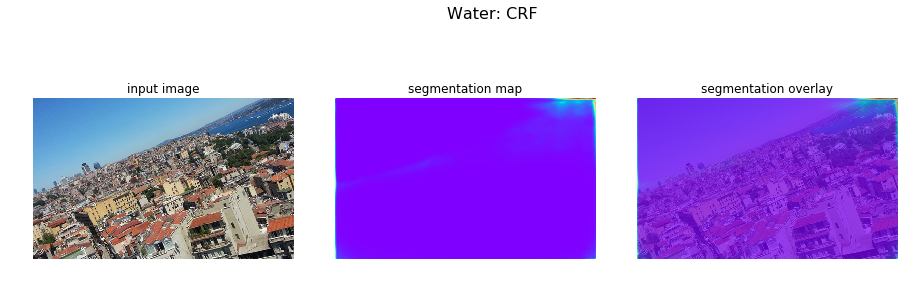

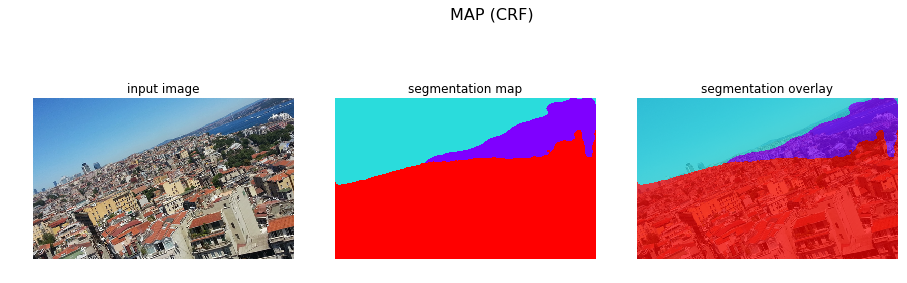

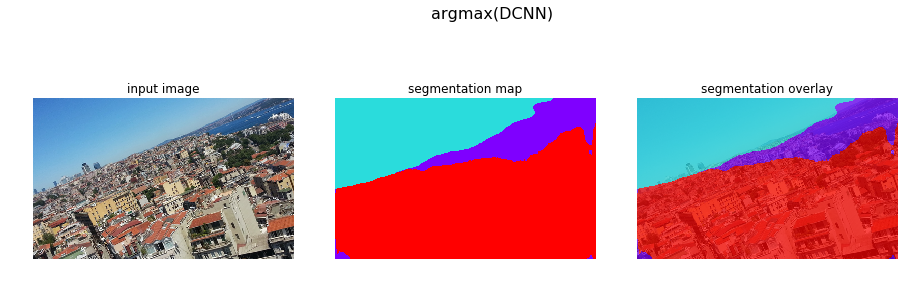

In [92]:
vis_segmentation(img_resized, dcnn_probs[:,:,0], 'Ground: DCNN')
vis_segmentation(img_resized, Q_0, 'Ground: CRF')

vis_segmentation(img_resized, dcnn_probs[:,:,1], 'Sky: DCNN')
vis_segmentation(img_resized, Q_1, 'Sky: CRF')

vis_segmentation(img_resized, dcnn_probs[:,:,2], 'Cloud: DCNN')
vis_segmentation(img_resized, Q_2, 'Cloud: CRF')

vis_segmentation(img_resized, dcnn_probs[:,:,3], 'Building: DCNN')
vis_segmentation(img_resized, Q_3, 'Building: CRF')

vis_segmentation(img_resized, dcnn_probs[:,:,4], 'Water: DCNN')
vis_segmentation(img_resized, Q_4, 'Water: CRF')

vis_segmentation(img_resized, crf_labels, 'MAP (CRF)')
vis_segmentation(img_resized, dcnn_labels, 'argmax(DCNN)') 

## Extract the Horizon

We can use the segmentation to find a basic horizon line separating the sky and ground.

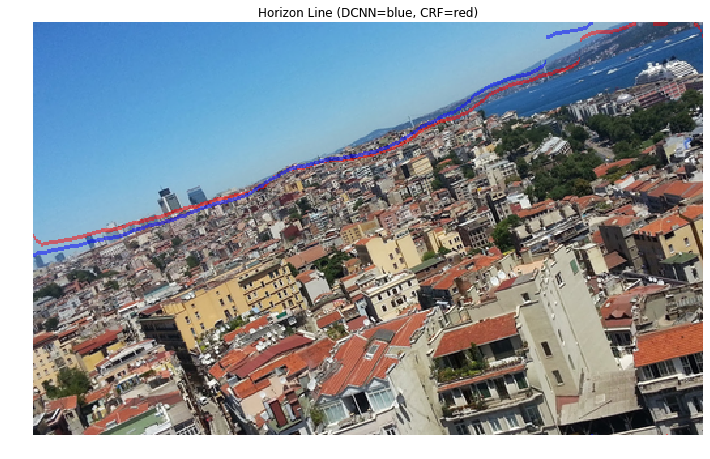

In [88]:
def draw_horizon(img, dcnn_labels, crf_labels):
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title('Horizon Line (DCNN=blue, CRF=red)')
    plt.axis('off')
    
    red = [255, 0, 0]
    blue = [0, 0, 255]

    def draw(labels, color, out_img):
        horizon = np.zeros_like(labels)
        for x in range(labels.shape[1]):
            sky_labels = np.nonzero(labels[:,x])
            if sky_labels[0].shape[0] != 0:
                y = np.max(sky_labels)
                out_img[y, x] = color
                out_img[y - 1, x] = color
                out_img[y + 1, x] = color
        return out_img

    def merge_labels(labels):
        labels = labels.copy()
        labels[labels == 2] = 1 # cloud -> sky
        labels[labels == 3] = 0 # building -> ground
        labels[labels == 4] = 0 # water -> ground
        return labels
    
    plt.imshow(img)
    horiz_img = np.array(img)
    
    draw(merge_labels(crf_labels), red, horiz_img)
    draw(merge_labels(dcnn_labels), blue, horiz_img)
    
    plt.imshow(horiz_img, alpha=.5, cmap=plt.cm.get_cmap('rainbow'))
    plt.show()

draw_horizon(img_resized, dcnn_labels, crf_labels)